# Predicting NYC Food Deserts - Modeling

This notebook will be focused on iterating over several models.

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as ctx
import os
from collections import Counter
import pickle

# visualization packages
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl

# modeling
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV, SelectKBest
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

# import functions
import sys
sys.path.append("..")
from src import *

# filter out warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import pickled dataset
df = pd.read_pickle('../data/eda_cleaned_df')

In [3]:
# set viewing options
pd.set_option('display.max_colwidth', -1)

# import data dictionary for reference
data_dict = pd.read_csv('../data/usda_nyc_data_dict.csv', index_col=0)
data_dict

Field  \
0   CensusTract            
1   State                  
2   County                 
3   Urban                  
4   POP2010                
5   OHU2010                
6   GroupQuartersFlag      
7   NUMGQTRS               
8   PCTGQTRS               
9   LILATracts_halfAnd10   
10  LILATracts_Vehicle     
11  HUNVFlag               
12  LowIncomeTracts        
13  PovertyRate            
14  MedianFamilyIncome     
15  LAhalfand10            
16  LATracts_half          
17  LATractsVehicle_20     
18  LAPOP05_10             
19  LALOWI05_10            
20  lapophalf              
21  lapophalfshare         
22  lalowihalf             
23  lalowihalfshare        
24  lakidshalf             
25  lakidshalfshare        
26  laseniorshalf          
27  laseniorshalfshare     
28  lawhitehalf            
29  lawhitehalfshare       
30  lablackhalf            
31  lablackhalfshare       
32  laasianhalf            
33  laasianhalfshare       
34  lanhopihalf            
35  lanhopihalfshare       
36  laaianhalf             
37  laaianhalfshare        
38  laomultirhalf          
39  laomultirhalfshare     
40  lahisphalf             
41  lahisphalfshare        
42  lahunvhalf             
43  lahunvhalfshare        
44  lasnaphalf             
45  lasnaphalfshare        
46  TractLOWI              
47  TractKids              
48  TractSeniors           
49  TractWhite             
50  TractBlack             
51  TractAsian             
52  TractNHOPI             
53  TractAIAN              
54  TractOMultir           
55  TractHispanic          
56  TractHUNV              
57  TractSNAP              

                                                                                                        LongName  \
0   Census tract                                                                                                   
1   State                                                                                                          
2   County                                                                                                         
3   Urban tract                                                                                                    
4   Population, tract total                                                                                        
5   Housing units, total                                                                                           
6   Group quarters, tract with high share                                                                          
7   Group quarters, tract population residing in, number                                                           
8   Group quarters, tract population residing in, share                                                            
9   Low income and low access tract measured at 1/2 mile for urban areas and 10 miles for rural areas              
10  Low income and low access tract using vehicle access or low income and low access tract measured at 20 miles   
11  Vehicle access, tract with low vehicle access                                                                  
12  Low income tract                                                                                               
13  Tract poverty rate                                                                                             
14  Tract median family income                                                                                     
15  Low access tract at 1/2 mile for urban areas and 10 miles for rural areas                                      
16  Low access tract at 1/2 mile                                                                                   
17  Low access tract using vehicle access and at 20 miles  in rural areas                                          
18  Low access, population at 1/2 mile for urban areas and 10 miles for rural areas, number                        
19  Low access, low-income population at 1/2 m

## Preprocessing for modeling

Prior to modeling data must be preprocessed:

- drop columns:
    - string columns
    - non-populated CT
    - any columns that could promote data leakage
    
- train test split

- scale data 

In [4]:
# drop string colomns
df.drop(['CensusTract', 'ct2010', 'boro_name'], inplace=True, axis=1)

In [5]:
# drop parks/cemeteries etc...
df = df[df['POP2010'] != 0]

In [6]:
# set X and y variables, drop columns that could incur data leakage
X = df.drop(['Urban','GroupQuartersFlag','LILATracts_halfAnd10','LILATracts_Vehicle',
             'HUNVFlag','LowIncomeTracts','LAhalfand10','LATracts_half','LATractsVehicle_20'], axis=1)
y = df['LILATracts_halfAnd10']

In [7]:
# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020,test_size=0.2)

In [8]:
# scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Logistic Regression

### with all features

First base model is Logistic Regression with all features. Class imbalance is dealt with by using the class_weight attribute. Going for high recall score to minimize false negatives. The rationale being there is such a large class imbalnace, we don't want to miss classifying any postive food deserts. Secondary metric is f1 score as to maximize harmonic mean. 

- instantiate model
- fit to training data
- predict on train and test data
- create function to easily retrieve scoring metrics from both test and train split

In [9]:
# instantiate model
lr = LogisticRegression(class_weight='balanced')

# fit model
lr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [10]:
# get predictions
y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)

In [11]:
# custom function that takes in several agruments and prints neatly formatted scoring metrics
get_model_scores('Logistic Regression', y_train, y_train_pred_lr, y_test, y_test_pred_lr)

Below are the scoring metrics for Logistic Regression model


Train Logistic Regression Accuracy: 0.9573598130841121
Test Logistic Regression Accuracy: 0.9649532710280374


Train Logistic Regression F1: 0.39669421487603307
Test Logistic Regression F1: 0.4444444444444444


Train Logistic Regression Recall: 1.0
Test Logistic Regression Recall: 0.8571428571428571


Train Logistic Regression Precision: 0.24742268041237114
Test Logistic Regression Precision: 0.3


<u>Model Evaluation</u>

- High recall score with a .85
- Secondary score of f1 is very low with .44
- However, precision score is even lower on test data with .3 which measures of those food deserts that were predicted as True, how many of those are actually True.
- Accuracy is high simply because of the class imbalance

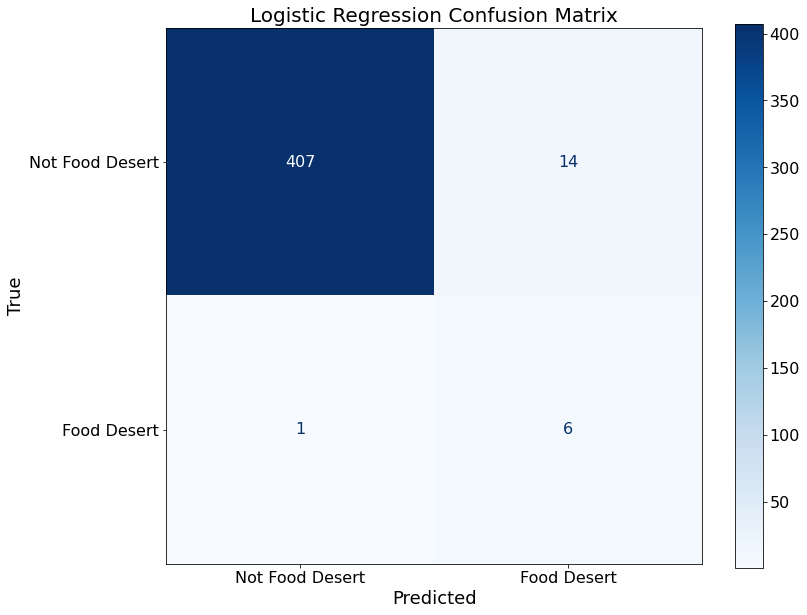

In [12]:
confusion_matrix(lr, X_test, y_test, 'Logistic Regression Confusion Matrix', normalize=None)

14 False Positives indicate low precision score, however 1 False Negatives align with the desired metric of Recall score. 

In [13]:
# create a dtaframe to identify which coeficient goes with which feature.
coef=list(lr.coef_[0])
col=X.columns
final_coef={}
for i in range(len(coef)):
    final_coef[col[i]]=coef[i]
final_coef=pd.DataFrame(final_coef,index=[0]).T
final_coef.columns=['Coeficients']
final_coef=final_coef.sort_values(ascending=False,by='Coeficients')
print(final_coef.head(5))
print(final_coef.tail(5))

                 Coeficients
lalowihalfshare  5.584942   
lahunvhalfshare  4.645157   
LALOWI05_10      3.079864   
lalowihalf       3.076999   
lahunvhalf       2.447946   
                    Coeficients
County_New York    -1.077532   
lawhitehalfshare   -1.343585   
lawhitehalf        -1.404572   
rateTractAsian     -1.779767   
MedianFamilyIncome -2.223931   


### with GridSearch

In [14]:
LogisticRegression()

LogisticRegression()

In [15]:
# set parameters for Gridsearch
lr_param = {
    'penalty':['l1', 'l2'],
    'C':np.logspace(-4, 4, 20),
    'solver':['lbfgs', 'liblinear'],
    'max_iter':[100, 300, 500, 1000],
}

# instantiate new Logistic Regression model
lr_grid = LogisticRegression(class_weight='balanced')

In [16]:
# instantiate Gridsearch classifier
grid_lr = GridSearchCV(estimator=lr_grid, param_grid=lr_param, scoring='recall', cv=5, verbose=True, n_jobs=-1)

In [17]:
# fit to training data
best_grid_lr = grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


In [18]:
# find best Gridsearch parameters
best_grid_lr.best_params_

{'C': 0.0001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}

In [19]:
# predict on train and test data
y_train_pred_lr_grid = best_grid_lr.predict(X_train)
y_test_pred_lr_grid = best_grid_lr.predict(X_test)


In [20]:
# use custom function to get Gridsearch Logistic Regression sCores
get_model_scores("Logistic Regression w/ Gridsearch", y_train, y_train_pred_lr_grid, y_test, y_test_pred_lr_grid)

Below are the scoring metrics for Logistic Regression w/ Gridsearch model


Train Logistic Regression w/ Gridsearch Accuracy: 0.8066588785046729
Test Logistic Regression w/ Gridsearch Accuracy: 0.8060747663551402


Train Logistic Regression w/ Gridsearch F1: 0.1266490765171504
Test Logistic Regression w/ Gridsearch F1: 0.1443298969072165


Train Logistic Regression w/ Gridsearch Recall: 1.0
Test Logistic Regression w/ Gridsearch Recall: 1.0


Train Logistic Regression w/ Gridsearch Precision: 0.0676056338028169
Test Logistic Regression w/ Gridsearch Precision: 0.07777777777777778


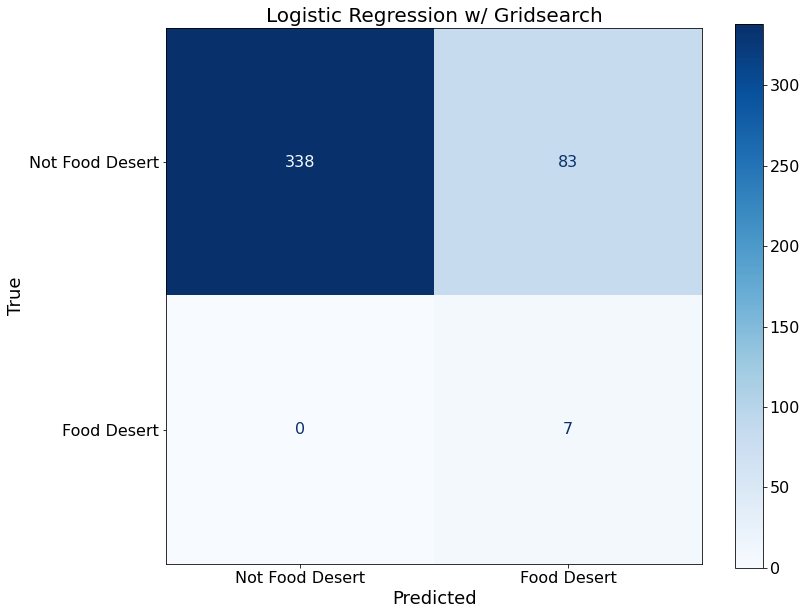

In [21]:
# view confustion matrix
confusion_matrix(grid_lr, X_test, y_test, 'Logistic Regression w/ Gridsearch', normalize=None)

Allowing GridSearch to find best parameters using `recall` as a the scoring metric, returned a perfect recall score, however there were many false positives which resulted in a low f1 score. When attempting Gridsearch with any other scoring metric returned much lower scores all around. 

For example:

- The solver `liblinear` solver choice makes sense because it is better at dealing with the optimzation problem for smaller datasets. 

- Also lowering the lambda regulator `C` to .0001 makes sense as it would strengthen the regularization. 

That said, the first Logistic Regression model with all features and default parameters (except class balancing) outputed a more balanced score. 

### with Recursive Feature Elimination (RFE)

Next Logistic Regression with RFE. The baseline model included all features and had a high Recall score, however a low F1 score. 

- reinstantiate model
- use LR as estimater in RFECV with F1 score
- fit RFECV to training data
- get RFE features
- create dataframe with only RFE features
- train test split
- scale data
- fit RFE LR model on training data
- predict on test data
- run metrics
- evaluate model
- plot confusion matrix
- isolate coefficients

In [22]:
# instantiate model
lr = LogisticRegression()

# run RFECV with LR estimator
selector = RFECV(estimator=lr, step=1, cv=5, scoring='f1', n_jobs=-1)

# fit RFE to training data
selector.fit(X_train, y_train)

# get RFE features
rfe_features = X.columns[(selector.get_support())]

In [23]:
# create df with ranking of coefficients
rfe_lr_df = pd.DataFrame(selector.ranking_, index=X.columns, columns=['Rank']).sort_values(by='Rank', ascending=True)

In [24]:
# preview df
rfe_lr_df.head()

Rank
lahunvhalfshare   1   
LALOWI05_10       1   
lalowihalf        1   
lalowihalfshare   1   
lanhopihalfshare  2

In [25]:
rfe_lr_1 = rfe_lr_df[rfe_lr_df['Rank'] == 1]

In [26]:
# optimal number of features
selector.n_features_

4

In [27]:
# set X and Y variables
X_rfe = df[rfe_features]
Y = y.copy()

In [28]:
# instantiate model
lr2=LogisticRegression(class_weight="balanced")

In [29]:
# train test split
X_train2,X_test2,y_train2,y_test2=train_test_split(X_rfe,Y,random_state=2020, test_size=.2)

In [30]:
# scale data
scaler = MinMaxScaler()
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [31]:
# fit on training data
lr2.fit(X_train2,y_train2)

# predict
y_train_pred_lr2 = lr2.predict(X_train2)
y_test_pred_lr2 = lr2.predict(X_test2)

In [32]:
get_model_scores('Logistic Regression w/RFE', y_train2, y_train_pred_lr2, y_test2, y_test_pred_lr2)

Below are the scoring metrics for Logistic Regression w/RFE model


Train Logistic Regression w/RFE Accuracy: 0.9485981308411215
Test Logistic Regression w/RFE Accuracy: 0.9672897196261683


Train Logistic Regression w/RFE F1: 0.34328358208955223
Test Logistic Regression w/RFE F1: 0.5


Train Logistic Regression w/RFE Recall: 0.9583333333333334
Test Logistic Regression w/RFE Recall: 1.0


Train Logistic Regression w/RFE Precision: 0.20909090909090908
Test Logistic Regression w/RFE Precision: 0.3333333333333333


Logistic Regression with RFE feature selection has a perfect Recall score on test data, however a .5 F1 score. Goal is to have more of a balance between Recall and F1. 

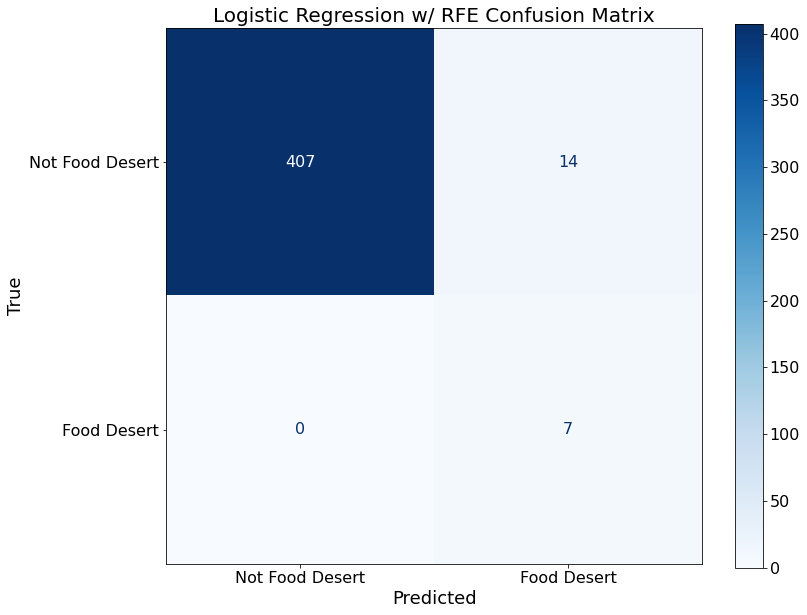

In [33]:
confusion_matrix(lr2, X_test2, y_test2, 'Logistic Regression w/ RFE Confusion Matrix', normalize=None)

In [34]:
# create list of coeficients weight
coef= sorted(list(lr2.coef_[0]), reverse=True)

In [35]:
# add coef column to rfe ranked 1 df
rfe_lr_1['coef_scores'] = coef

In [36]:
# view ranking and score of top coefficents
rfe_lr_1

Rank  coef_scores
lahunvhalfshare  1     8.717076   
LALOWI05_10      1     5.249404   
lalowihalf       1     3.915062   
lalowihalfshare  1     3.912224

Running RFECV with Logistic Regression creates `recall` scores of 1 and `f1` of .5 on test data. It found the optimal number of features to be 4. 

These are:

- `lahunvhalfshare` - low-access househoulds with no vehicle (share)
- `LALOWI05_10` - low-access/low-income greater then 1/2 mile from supermarkets count (urban) 10 miles (rural)
- `lalowihalf` - low-access/low-income greater then 1/2 mile from supermarkets (count)
- `lalowihalfshare` - low-access/low income greater then 1/2 mile from supermarkets (share)

This reduced feature selection method tells us low-access, low-income and lack of vehicle access, have more of an effect on the creation of food deserts then all other features in this dataset. However, still would like more of a balanced `f1` score without so many false positives. 

## Decision Tree Classifier (DTC)

Next will try DTC model.

In [37]:
# instantiate model
dtc = DecisionTreeClassifier(criterion='gini', max_depth=5, class_weight='balanced', random_state=1)

# fit on training data
dtc = dtc.fit(X_train, y_train)

# predict
y_train_pred_dtc = dtc.predict(X_train)
y_test_pred_dtc  = dtc.predict(X_test)

In [38]:
get_model_scores('Decision Tree', y_train, y_train_pred_dtc, y_test, y_test_pred_dtc)

Below are the scoring metrics for Decision Tree model


Train Decision Tree Accuracy: 0.9789719626168224
Test Decision Tree Accuracy: 0.9789719626168224


Train Decision Tree F1: 0.5714285714285715
Test Decision Tree F1: 0.5263157894736842


Train Decision Tree Recall: 1.0
Test Decision Tree Recall: 0.7142857142857143


Train Decision Tree Precision: 0.4
Test Decision Tree Precision: 0.4166666666666667


High Recall on training data, however was overfit with major drop off on test data. F1 score stayed similar. 

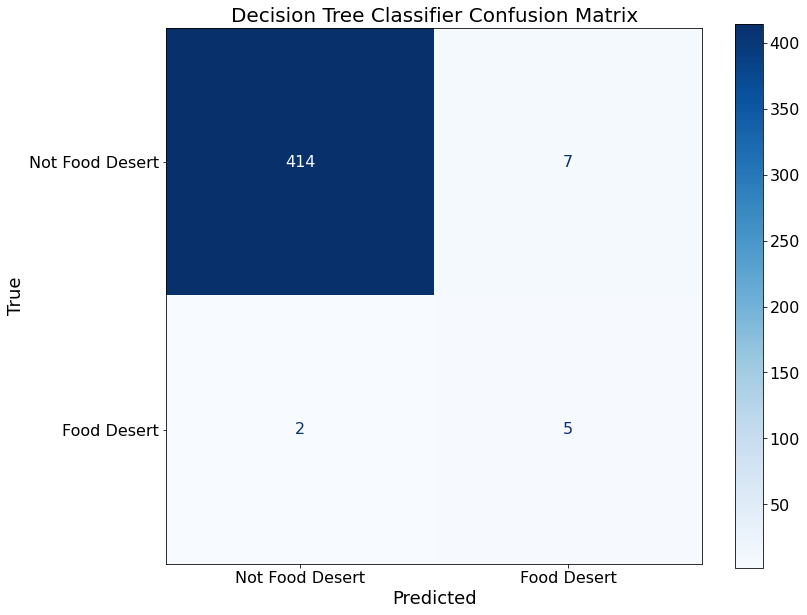

In [39]:
confusion_matrix(dtc, X_test, y_test, 'Decision Tree Classifier Confusion Matrix', normalize=None)

Too many False Negatives and would like a higher f1 score for a more balanced final metric.

### with GridSearch

In [40]:
dtc_params = {
    'max_depth': range(1,21,1),
    'criterion':['gini', 'entropy'],
    'min_samples_split': range(1,11,1)
    }

# instantiate new DTC model
dtc_grid = DecisionTreeClassifier(class_weight='balanced', random_state=2)

In [41]:
grid_dtc = GridSearchCV(estimator=dtc_grid, 
                        param_grid=dtc_params, 
                        cv=5, 
                        verbose=1, 
                        n_jobs=-1)

In [42]:
grid_dtc.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=2),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 21),
                         'min_samples_split': range(1, 11)},
             verbose=1)

In [43]:
grid_dtc.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2}

In [44]:
y_train_pred_grid_dtc = grid_dtc.predict(X_train)
y_test_pred_grid_dtc = grid_dtc.predict(X_test)

In [45]:
get_model_scores("Decision Tree Classifier w/ GridSearch", y_train, y_train_pred_grid_dtc, y_test, y_test_pred_grid_dtc)

Below are the scoring metrics for Decision Tree Classifier w/ GridSearch model


Train Decision Tree Classifier w/ GridSearch Accuracy: 1.0
Test Decision Tree Classifier w/ GridSearch Accuracy: 0.9976635514018691


Train Decision Tree Classifier w/ GridSearch F1: 1.0
Test Decision Tree Classifier w/ GridSearch F1: 0.923076923076923


Train Decision Tree Classifier w/ GridSearch Recall: 1.0
Test Decision Tree Classifier w/ GridSearch Recall: 0.8571428571428571


Train Decision Tree Classifier w/ GridSearch Precision: 1.0
Test Decision Tree Classifier w/ GridSearch Precision: 1.0


Saving figure dtc_con_matrix_with_grid


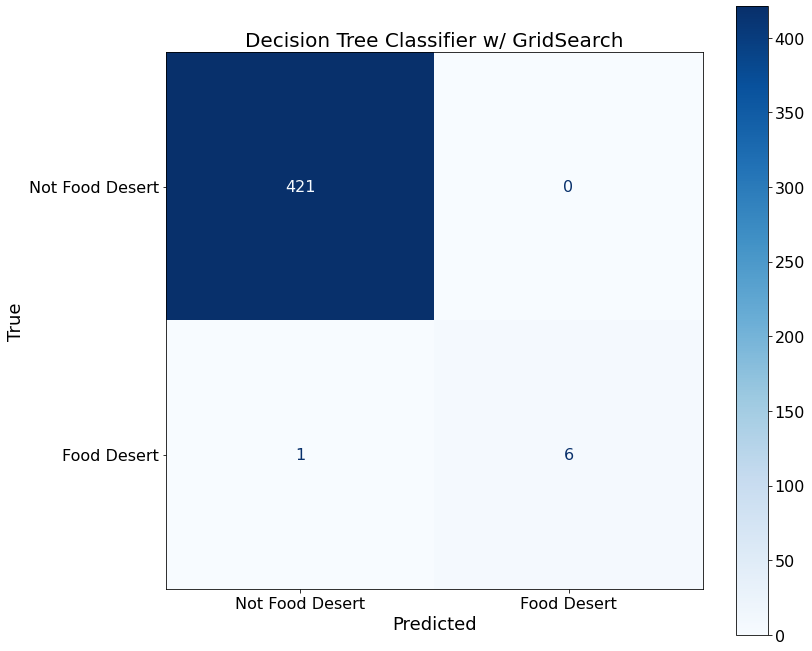

In [46]:
confusion_matrix(grid_dtc, X_test, y_test, "Decision Tree Classifier w/ GridSearch", normalize=None)
save_fig('dtc_con_matrix_with_grid')

Using Gridsearch with Decision Tree Classifier, proved to provide the most balance betwee `recall` and `f1` thus far, with .85 and .92 on the test data respectively. All scoring metrics were 100% on training data, which is typical of DTC as it can easily be overfit on training data. 

GridSearch settled on the following paraemters:

- `entropy` as the criterion, this makes sense because it measures the impurity, disorder or uncertainty controlling how a DTC decides to split the data. The first DTC model used `gini`  as a criterion which will split the feature with the highest infomration gain first.
- `max_depth` stayed the same as the first model at 5
- `min_samples_split` statyed the same as the default at 2

## Random Forest Classifier

Since Decision Tree with GridSearch was perfect on training data and almost perfect on test, try Random Forest to see if score can be 100% on both. 

- Instantiate model
- fit to training data
- predict on train and test
- get model scores through custom function
- plot confusion matrix through custom function
- try Gridsearch with Random Forest

In [47]:
# instantiate Random Forest
rf = RandomForestClassifier(random_state = 1,
                            class_weight='balanced')

# fit to training data
rf.fit(X_train, y_train)

# predict
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

# get scores
get_model_scores("Random Forest", y_train, y_train_pred_rf, y_test, y_test_pred_rf)

Below are the scoring metrics for Random Forest model


Train Random Forest Accuracy: 1.0
Test Random Forest Accuracy: 0.9813084112149533


Train Random Forest F1: 1.0
Test Random Forest F1: 0.3333333333333333


Train Random Forest Recall: 1.0
Test Random Forest Recall: 0.2857142857142857


Train Random Forest Precision: 1.0
Test Random Forest Precision: 0.4


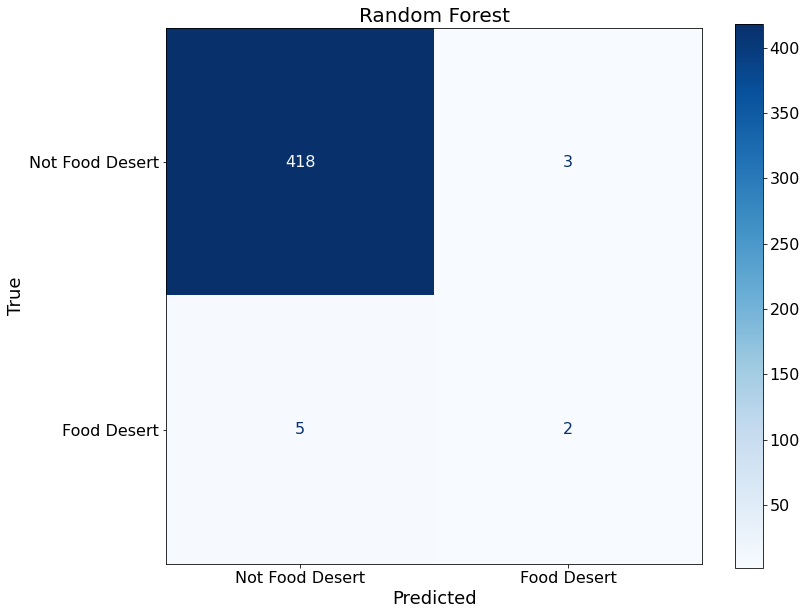

In [48]:
# plot confusion matrix
confusion_matrix(rf, X_test, y_test, "Random Forest", normalize=None)

Base Random Forest performed extremely poorly, will try to GridSearch parameters to get better scoring.

### with GridSearch

In [49]:
# # instantiate new model for Gridsearch
# rf_grid = RandomForestClassifier(class_weight='balanced', random_state=1)

# # define parameters
# rf_params = {
#     'criterion':['gini', 'entropy'],
#     'max_depth':range(1,10,1),
#     'n_estimators':range(1,100,10),
#     'max_leaf_nodes':[None, 10, 20, 30, 40],
#     'min_samples_leaf':range(1,10,1),
#     'max_features':[None, 'auto']
    
# }

# # instantiate Gridsearch 
# grid_rf = GridSearchCV(estimator=rf_grid,
#                        param_grid=rf_params, 
#                        n_jobs=-1,
#                        verbose=1,
#                       cv=5)

# # fit to training data
# grid_rf.fit(X_train, y_train)

In [50]:
# # pickle Random Forest Gridsearch
# pickle_out = open('../data/grid_rf_model.pickle', 'wb')
# pickle.dump(grid_rf, pickle_out)
# pickle_out.close()


In [51]:
# import pickled Random Forest Gridsearch model
pickle_in = open('../data/grid_rf_model.pickle', 'rb')
grid_rf = pickle.load(pickle_in)
pickle_in.close()

In [52]:
grid_rf.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 3,
 'n_estimators': 31}

In [53]:
# predict
y_train_pred_grid_rf = grid_rf.predict(X_train)
y_test_pred_grid_rf = grid_rf.predict(X_test)

In [54]:
# get scores
get_model_scores("Random Forest w/ GridSearch", y_train, y_train_pred_grid_rf, y_test, y_test_pred_grid_rf)

Below are the scoring metrics for Random Forest w/ GridSearch model


Train Random Forest w/ GridSearch Accuracy: 1.0
Test Random Forest w/ GridSearch Accuracy: 0.9929906542056075


Train Random Forest w/ GridSearch F1: 1.0
Test Random Forest w/ GridSearch F1: 0.7272727272727273


Train Random Forest w/ GridSearch Recall: 1.0
Test Random Forest w/ GridSearch Recall: 0.5714285714285714


Train Random Forest w/ GridSearch Precision: 1.0
Test Random Forest w/ GridSearch Precision: 1.0


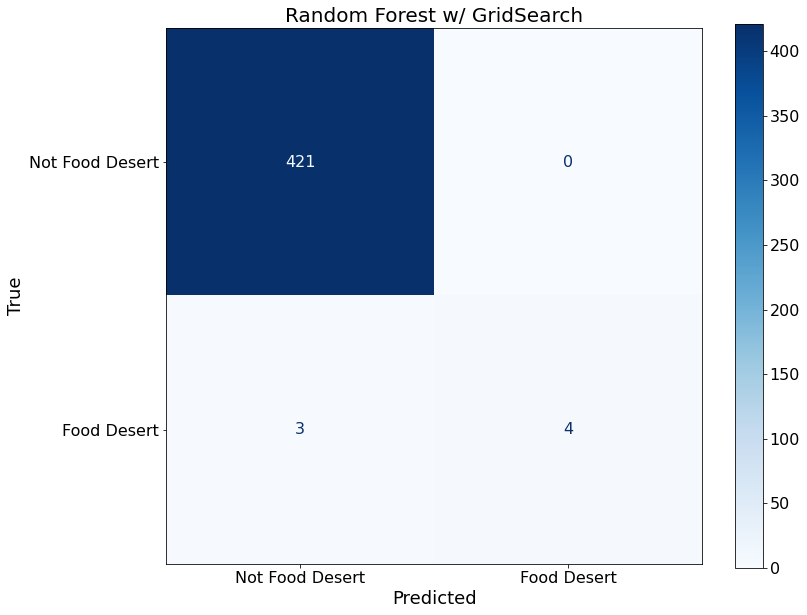

In [55]:
confusion_matrix(grid_rf, X_test, y_test, "Random Forest w/ GridSearch", normalize=None)

Even with GridSearching several parameters, Random Forest with GridSearch did not fair better then a simple Decision Tree model. This is most likely due too the low-access/low-income features having the most predictive power, and a relatively small dataset.

## XG Boost

Next will try XG Boost. In order to deal with class imbalance, need to estimate the scale of the positive class in regard to the negative. Therefore before instantiating model will utilize counter to get scale, which is 2109 divided by 31. 

- utilize counter to get positive scale
- set parameters for XG boost
- instantiate model
- set labels 
- fit to training data
- get predictions
- print metrics
- model evaluation
- plot confusion matrix
- plot feature importance

In [56]:
# count examples in each class
counter = Counter(y)

# estimate scale_pos_weight value
estimate = counter[0]/counter[1]
print('Estimate: %f' % estimate)

Estimate: 68.032258


In [57]:
# set parameters for XG boost model
params = {'objective':'binary:logistic',
        'colsample_bytree':0.5, 
        'subsample':0.5,
        'learning_rate':0.1,
        'max_depth':4, 
        'alpha':1,
        'n_estimators':130,
        'scale_pos_weight':68.032258}

In [58]:
# instantiate model
xg = xgb.XGBClassifier(**params)

# set labels on training data so that feature importance can be graphed with names
X_train = pd.DataFrame(X_train,columns=X.columns)
X_test = pd.DataFrame(X_test,columns=X.columns)

# fit to training data
xg.fit(X_train, y_train)

# predict
y_train_pred_xg = xg.predict(X_train)
y_test_pred_xg = xg.predict(X_test)

[08:54:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [59]:
get_model_scores('XG Boost', y_train, y_train_pred_xg, y_test, y_test_pred_xg)

Below are the scoring metrics for XG Boost model


Train XG Boost Accuracy: 1.0
Test XG Boost Accuracy: 0.9883177570093458


Train XG Boost F1: 1.0
Test XG Boost F1: 0.6666666666666666


Train XG Boost Recall: 1.0
Test XG Boost Recall: 0.7142857142857143


Train XG Boost Precision: 1.0
Test XG Boost Precision: 0.625


Saving figure xg_boost_con_matrix


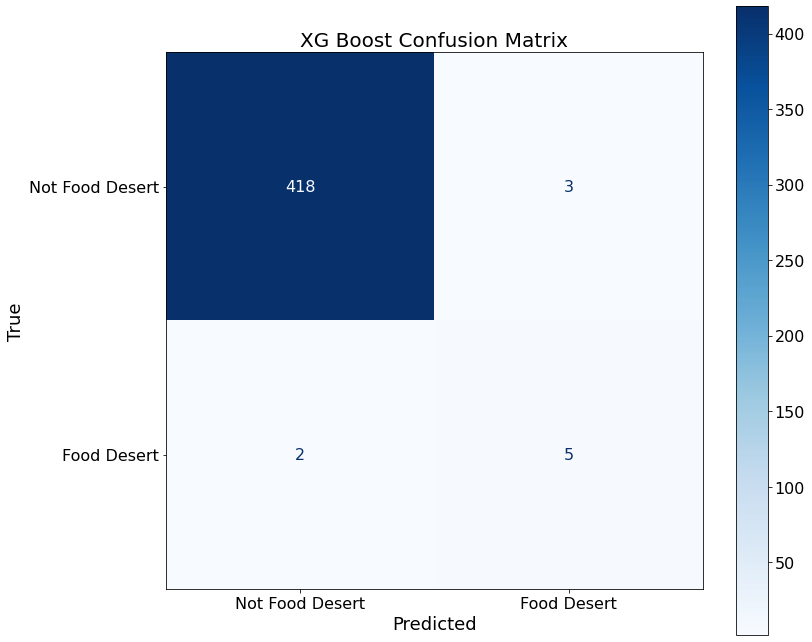

In [60]:
confusion_matrix(xg, X_test, y_test, 'XG Boost Confusion Matrix', normalize=None)
save_fig('xg_boost_con_matrix')

Model has definetly overfit on training data, however the .71 `Recall` and .66 `F1`, are pretty balanced will try with Gridsearch to see if any improvement can be made. 

### with GridSearch

In [61]:
# parameters to gridsearch
xg_grid_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': range(1,5,1)
    }

In [62]:
# instantiate model
xg_grid = XGBClassifier(scale_pos_weight = 68.032258, random_state=1)

# instantiate GridSearch
grid_xg = GridSearchCV(estimator=xg_grid,
                      param_grid=xg_grid_params,
                      cv=5,
                      n_jobs=-1,
                      verbose=1)

# fit to training data
grid_xg.fit(X_train, y_train)

# predict
y_train_pred_grid_xg = grid_xg.predict(X_train)
y_test_pred_grid_xg = grid_xg.predict(X_test)

# get scores
get_model_scores("XGBoost w/ GridSearch", y_train, y_train_pred_grid_xg, y_test, y_test_pred_grid_xg)

Fitting 5 folds for each of 540 candidates, totalling 2700 fits
[09:00:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Below are the scoring metrics for XGBoost w/ GridSearch model


Train XGBoost w/ GridSearch Accuracy: 1.0
Test XGBoost w/ GridSearch Accuracy: 0.9953271028037384


Train XGBoost w/ GridSearch F1: 1.0
Test XGBoost w/ GridSearch F1: 0.8333333333333333


Train XGBoost w/ GridSearch Recall: 1.0
Test XGBoost w/ GridSearch Recall: 0.7142857142857143


Train XGBoost w/ GridSearch Precision: 1.0
Test XGBoost w/ GridSearch Precision: 1.0


In [63]:
# get best parameters
grid_xg.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.5,
 'max_depth': 3,
 'min_child_weight': 1,
 'subsample': 1.0}

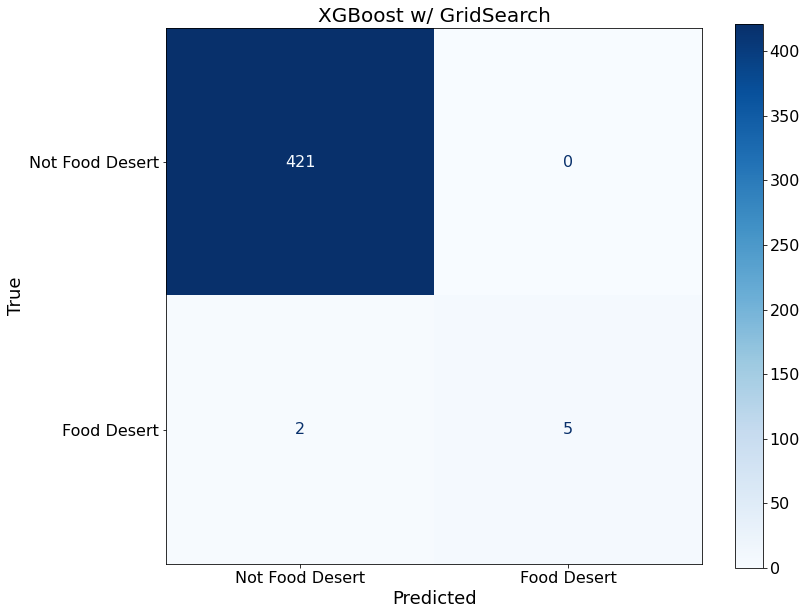

In [64]:
confusion_matrix(grid_xg, X_test, y_test, "XGBoost w/ GridSearch", normalize=None)

Although improvement was made upon XGBoost model, Decision Tree Model was a better overall predictor of Food Deserts on the test set.

## <u>Conclusion</u>

#### Redo DTC model with GridSearch Parameters to create visual

In [65]:
# instantiate new DTC with Gridsearch parameters
dtc2 = DecisionTreeClassifier(class_weight='balanced',
                             random_state=2,
                             criterion='entropy',
                             max_depth=5,
                             min_samples_split=2)

# fit to training data
dtc2.fit(X_train, y_train)

# predict
y_train_pred_dtc2 = dtc2.predict(X_train)
y_test_pred_dtc2 = dtc2.predict(X_test)

# get model scores
get_model_scores("Decision Tree Classifier 2", y_train, y_train_pred_dtc2, y_test, y_test_pred_dtc2)

Below are the scoring metrics for Decision Tree Classifier 2 model


Train Decision Tree Classifier 2 Accuracy: 1.0
Test Decision Tree Classifier 2 Accuracy: 0.9976635514018691


Train Decision Tree Classifier 2 F1: 1.0
Test Decision Tree Classifier 2 F1: 0.923076923076923


Train Decision Tree Classifier 2 Recall: 1.0
Test Decision Tree Classifier 2 Recall: 0.8571428571428571


Train Decision Tree Classifier 2 Precision: 1.0
Test Decision Tree Classifier 2 Precision: 1.0


Saving figure decision_tree_plot


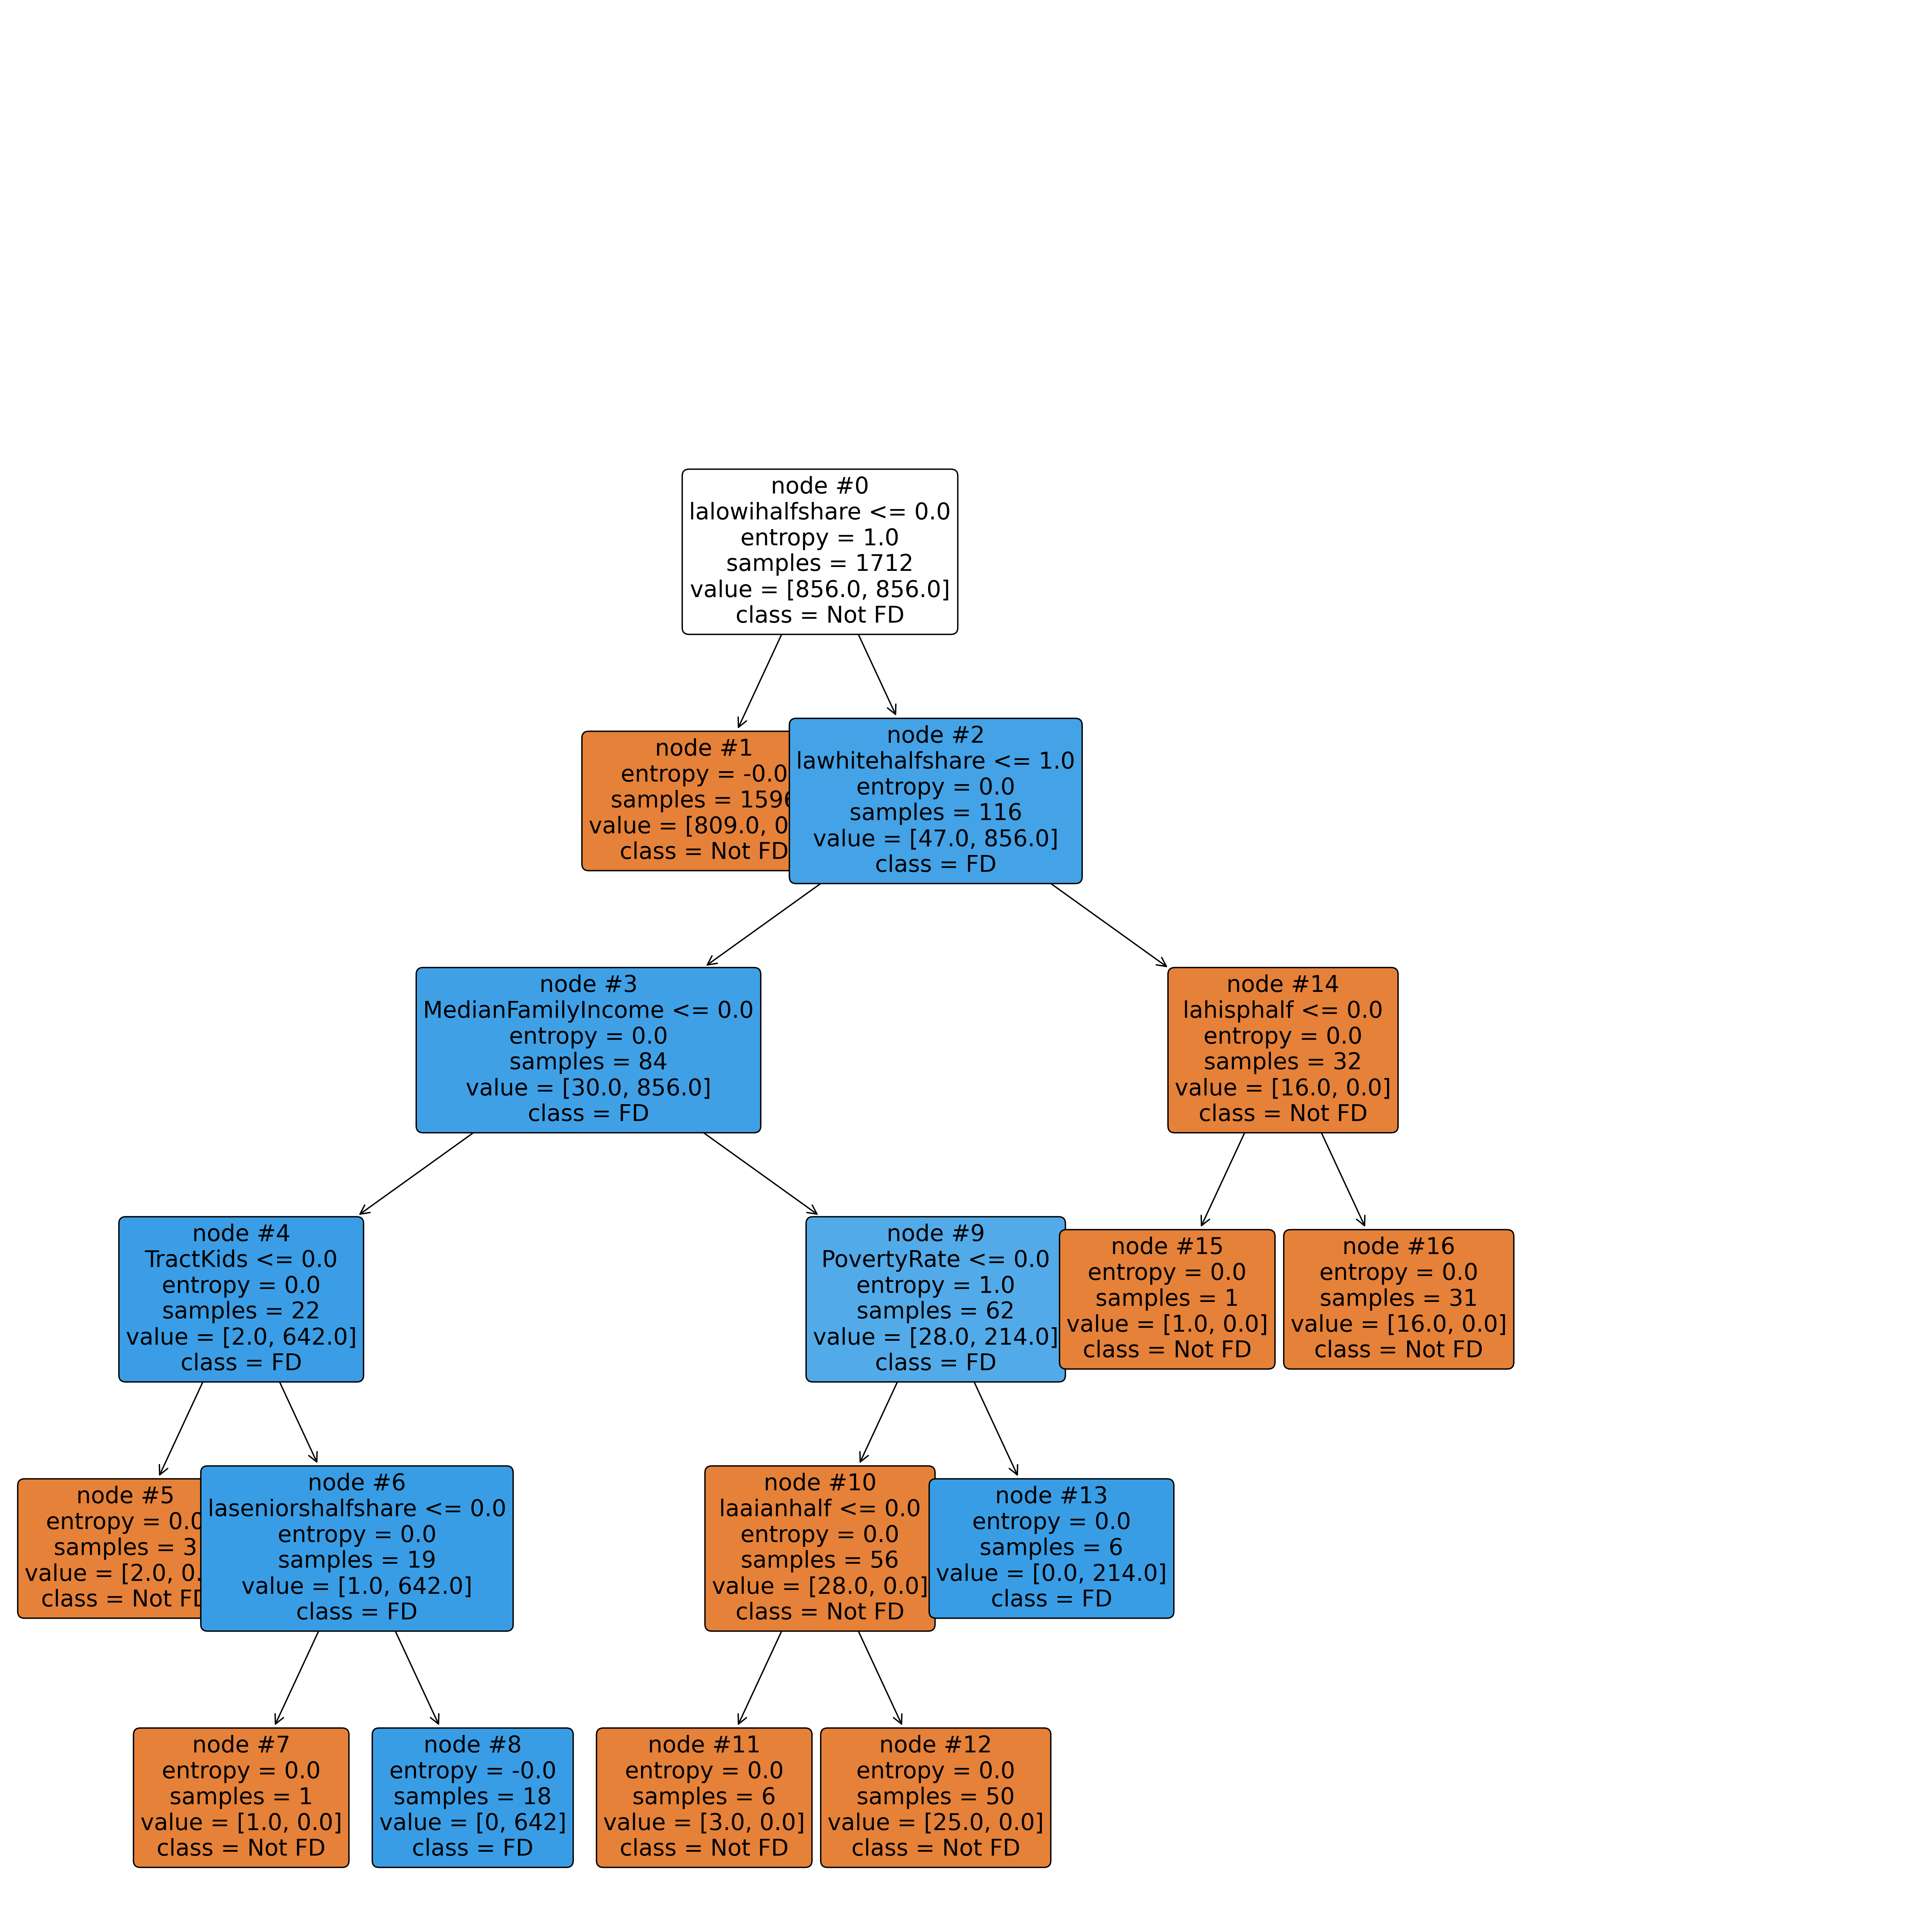

In [66]:
# reset parameters to default
mpl.rcParams.update(mpl.rcParamsDefault)
# visualize dtc2
fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(20,20), dpi=300)
out = tree.plot_tree(dtc2,
                         feature_names=X.columns,
                         class_names=['Not FD', 'FD'],
                          filled=True,
                          node_ids=True,
                          rounded=True,
                         fontsize=17,
                         precision=0)

save_fig('decision_tree_plot', transparent=True)

Our final model is Decision Tree Classifier (DTC) with GridSearch. 

The features that DTC split on (in this order) to get the most accurate result were:

1) `lalowihalfshare` - Share of tract population that are low income individuals beyond 1/2 mile from supermarket

2) `lawhitehalfshare` - Share of tract population that are white beyond 1/2 mile from supermarke

3) `MedianFamilyIncome` - Tract median family income

4) `TractKids` - Total count of children age 0-17 in tract

5) `laseniorshalfshare` - Share of tract population that are seniors beyond 1/2 mile from supermarke

6) `PovertyRate` - Share of the tract population living with income at or below the Federal poverty thresholds for family size

7) `laaianhalf` - American Indian or Alaska Native population count beyond 1/2 mile from supermarket

8) `lahisphalf` - Hispanic or Latino ethnicity population count beyond 1/2 mile from supermarket

This highlights most important indicator of food deserts are share of tract that are low-access/low-income. Secondarily are share of tract that are white (or not white), followed by median income, count of kids, senior share, poverty rate, and finally by share of tract low-access American Indian/Alaskan Native or latinx.

This tells us that although that low-access and low-income are the primary indicators, share of white population within a given tract has a direct relation to weather or not it was classified as a food desert. That coupled with median income and poverty rate, count of kids/share of seniors and a few other demographic indicators, gives us almost a perfect result. 

Next step would be to utilize this model on newer data to predict food deserts per census tract, and verify if affected areas are covered under the FRESH Tax incentive. 

### Visualize Final Model Predictions on map 

In [67]:
# import in gdf for geospatial analysis
gdf_merge = pd.read_pickle('../data/gdf_merge')
gdf_merge = gpd.GeoDataFrame(gdf_merge)

In [68]:
# create df with only polygons for positive class
fddf = gdf_merge[gdf_merge['LILATracts_halfAnd10'] == 1]

In [69]:
# fill NaN values so that model can predict
gdf_merge.fillna(value=0, inplace=True)

In [70]:
# exclude categorical or object columns
gdf_merge = gdf_merge.select_dtypes(exclude=['object', 'category'])

In [71]:
# scale gdf_merge
scaler2 = MinMaxScaler()
scaled_gdf_merge = scaler2.fit_transform(gdf_merge.iloc[:,3:])

In [72]:
# predict on gdf
preds_dtc2 = dtc2.predict(scaled_gdf_merge)

In [73]:
# concat predictions to gdf for visualation of predictions
gdf_preds_dtc2 = pd.concat([gdf_merge.reset_index(),\
                            pd.Series(preds_dtc2)],\
                           axis=1).rename(columns={0:'Predicted Target'})

In [74]:
# view predicted target counts
gdf_preds_dtc2['Predicted Target'].value_counts()

0    2134
1    30  
Name: Predicted Target, dtype: int64

In [75]:
# set predicted target values where population equals zero to np. nan to show as missing values
gdf_preds_dtc2['Predicted Target'].loc[gdf_preds_dtc2['POP2010'] == 0] = np.nan

In [76]:
# create gdf of pos predictions
gdf_preds_pos_dtc2 = gdf_preds_dtc2[gdf_preds_dtc2['Predicted Target'] == 1]

Saving figure decision_tree_classifer_final_model_predictions


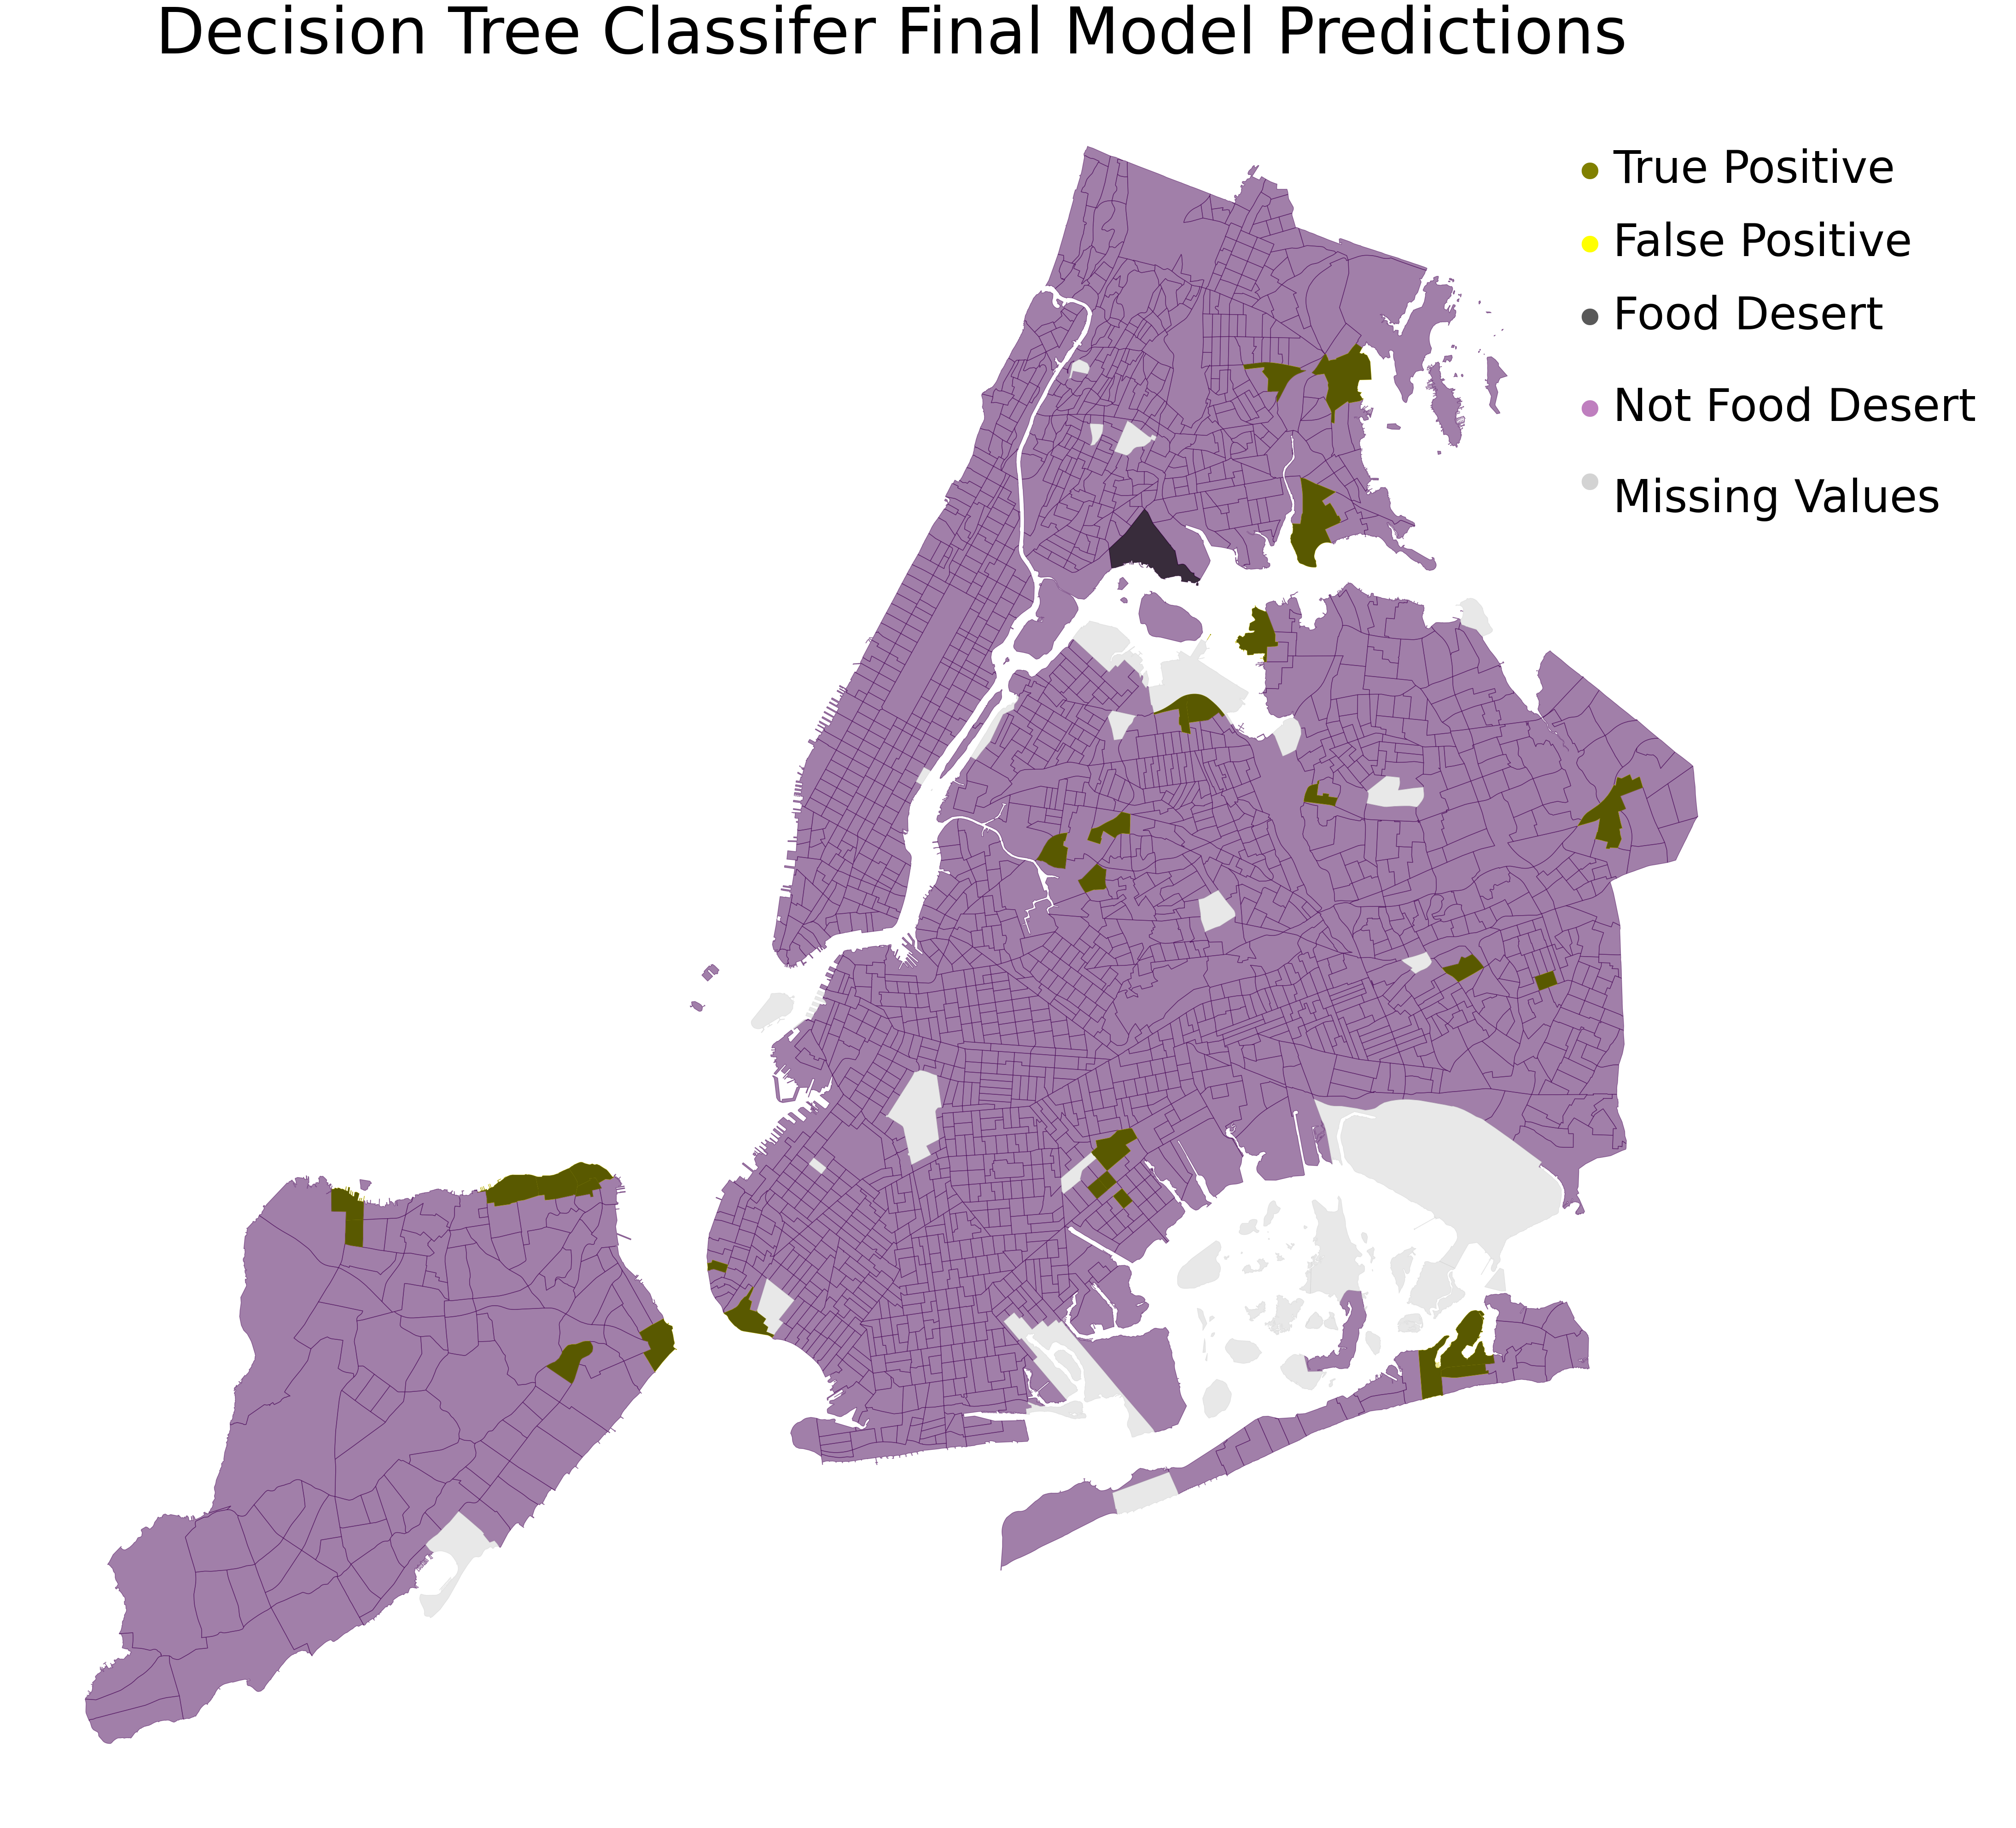

In [79]:
create_choropleth_map_pred(gdf_preds_dtc2, fddf, gdf_preds_pos_dtc2, 'Predicted Target', 'LILATracts_halfAnd10',\
                           'Predicted Target','viridis', 'Decision Tree Classifer Final Model Predictions', 'k')

Next step would be to overlay FRESH geometry to see coverage.

In [80]:
# read in FRESH geometry
gdf_fresh = gpd.read_file('../data/shp/gdf_fresh.shp')

Saving figure decision_tree_classifer_final_model_predictions_with_fresh


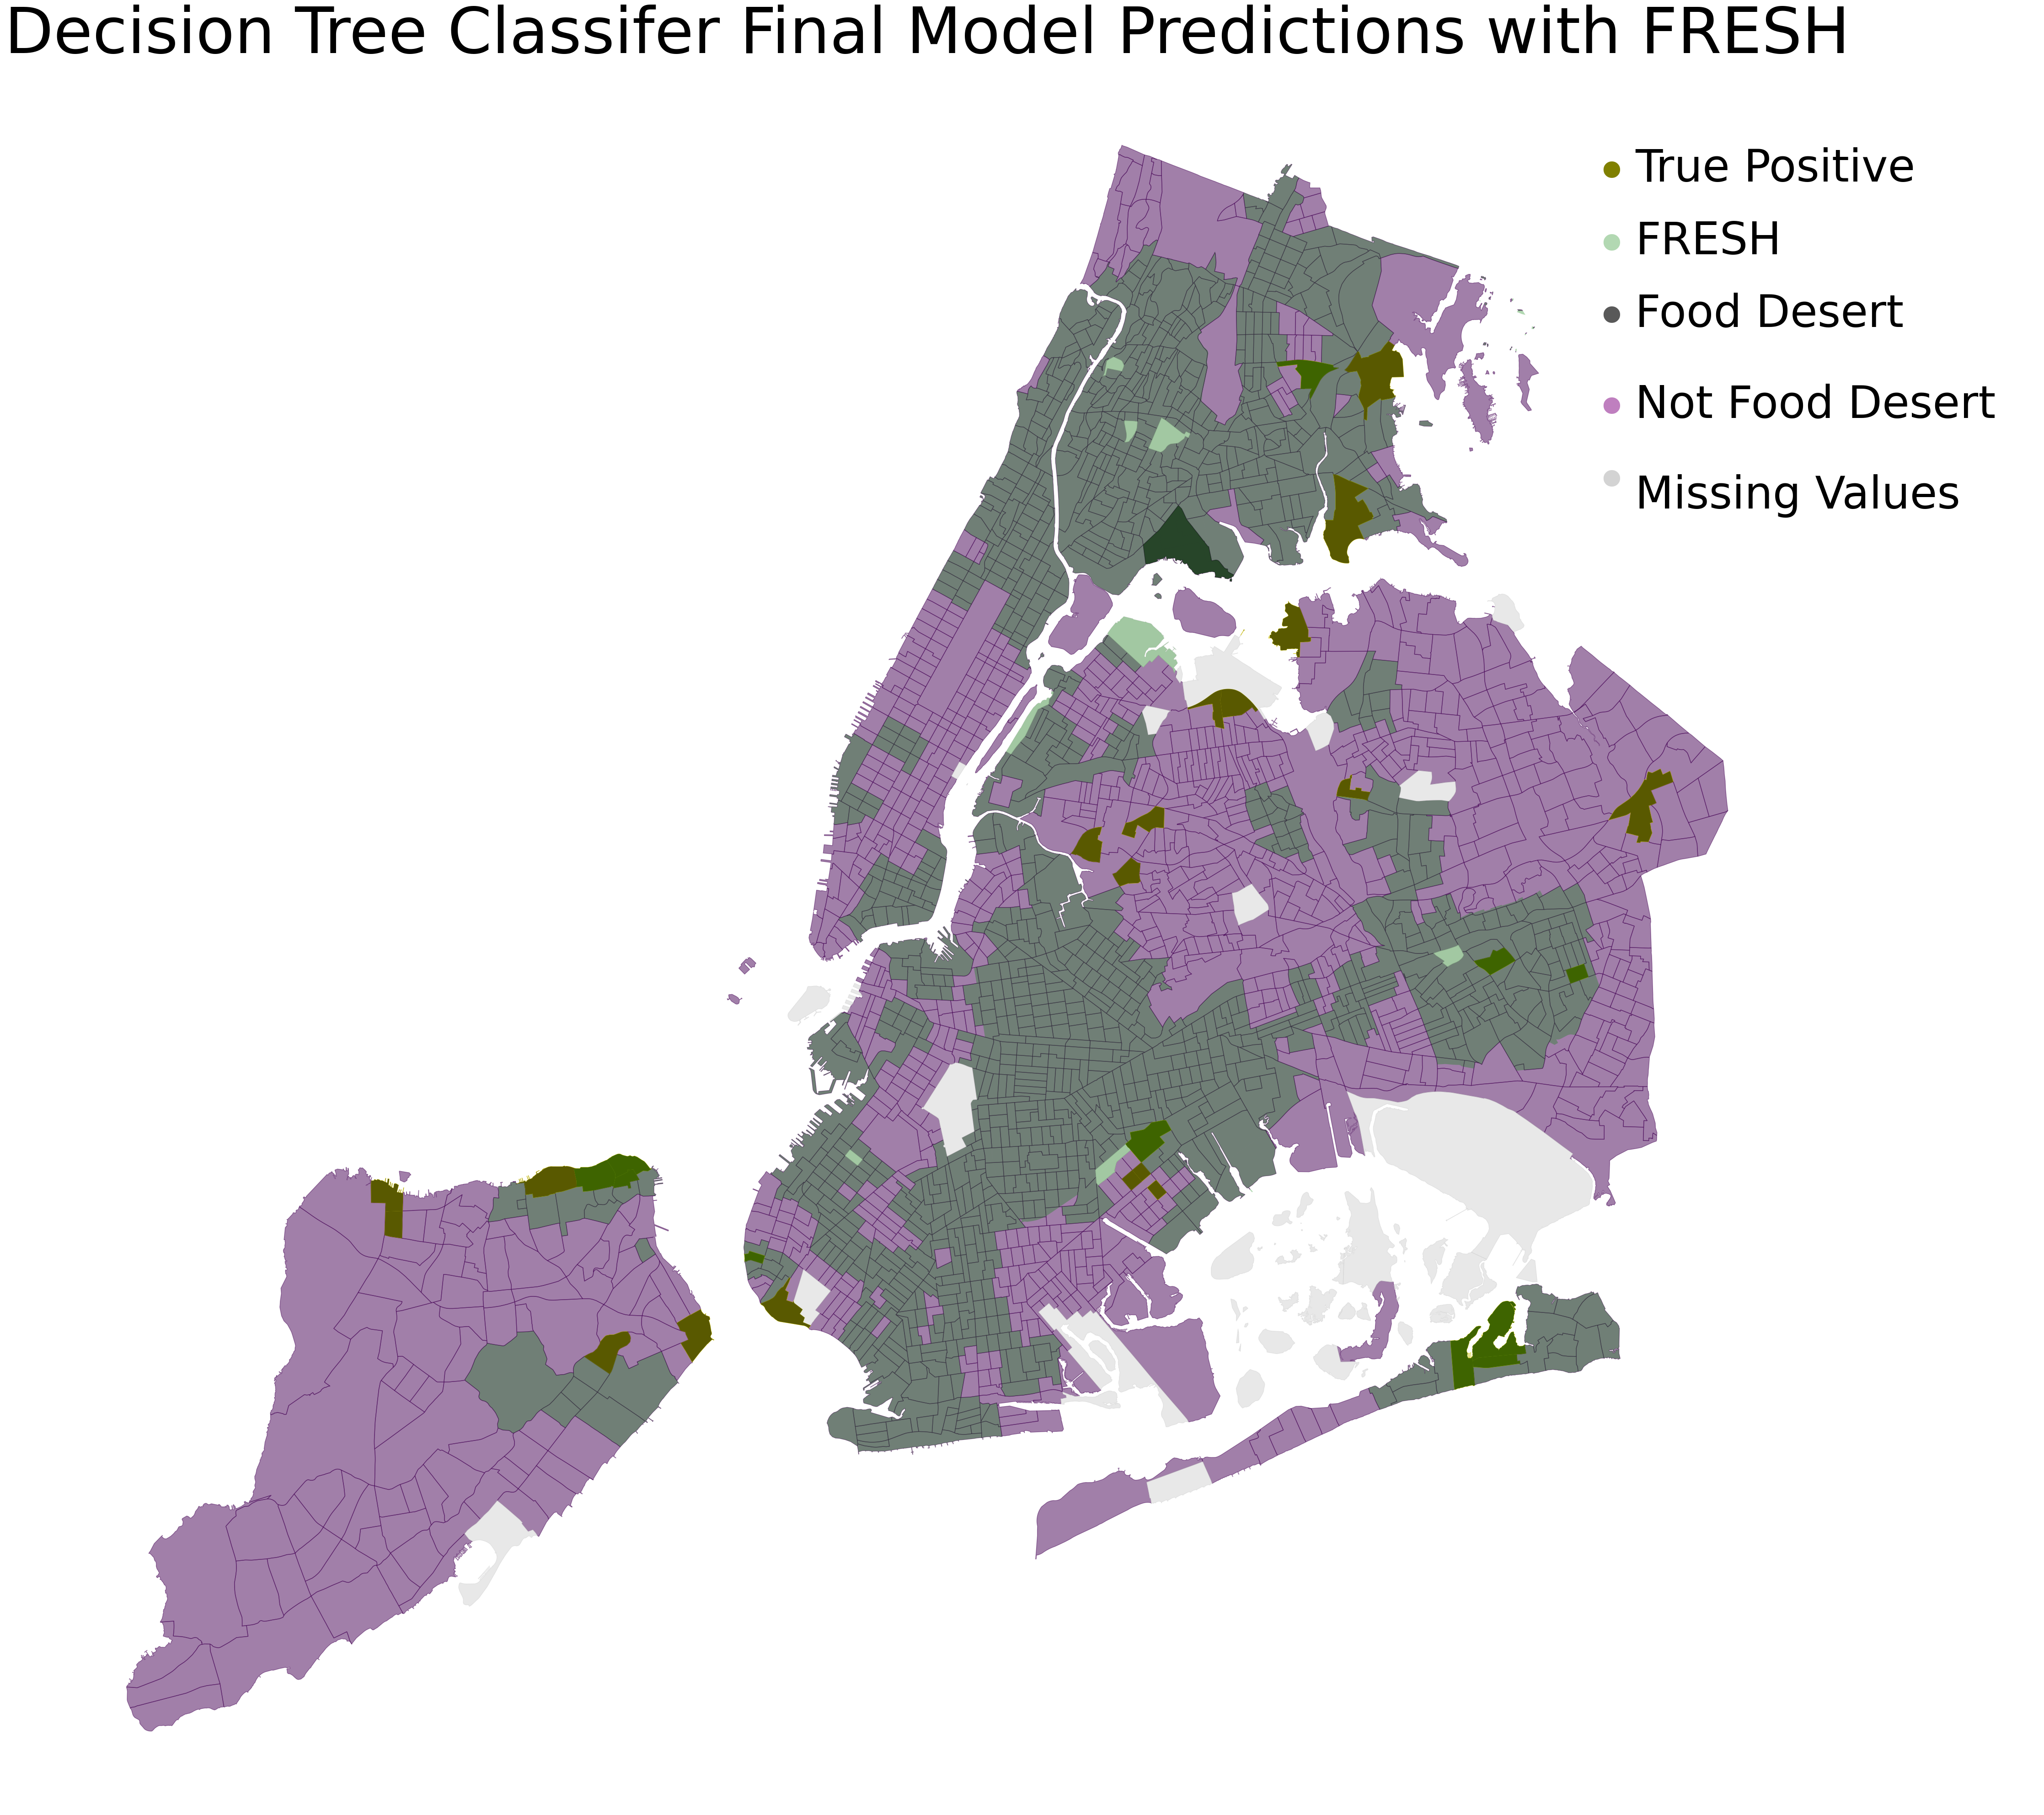

In [81]:
create_choropleth_map_pred_fresh(gdf_preds_dtc2, fddf, gdf_preds_pos_dtc2, gdf_fresh, 'Predicted Target',\
                            'LILATracts_halfAnd10', 'Predicted Target','name','viridis','Decision Tree Classifer Final Model Predictions with FRESH', 'k')